In [1]:
#"Hayvan Tanıma Git Repostory Oluşturuldu"

In [2]:
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, History
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import SGD

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # UYARILARI KAPATMA


/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-

In [3]:
#print(os.listdir("./images/train"))
SIZE = 299
EPOCH = 50
BATCH = 32
train_directory = "images/train/"
valid_directory = "images/valid/"
test_directory = "images/test/"

data_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                              validation_split=0.3)
test_aug = ImageDataGenerator(rotation_range=40,
                              width_shift_range=[0.2, 1.0],
                              height_shift_range=[0.2, 1.0],
                              shear_range=0.2,
                              rescale=1. / 255,
                              zoom_range=[0.2, 1.0],
                              horizontal_flip=True,
                              fill_mode="nearest",
                              vertical_flip=True,
                              brightness_range=[0.2, 1.0])
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
train_generator = data_aug.flow_from_directory(directory=train_directory,
                                               batch_size=BATCH,
                                               shuffle=True,
                                               class_mode="categorical",
                                               color_mode="rgb",
                                               target_size=(SIZE, SIZE),
                                               interpolation="nearest",
                                               subset="training",
                                               seed=42,
                                               save_to_dir="images/temp/"

                                               )
validation_generator = data_aug.flow_from_directory(directory=train_directory,
                                                    batch_size=BATCH,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(SIZE, SIZE),
                                                    interpolation="nearest",
                                                    subset="validation",
                                                    seed=42,
                                                    save_to_dir="images/temp/"
                                                    )
test_generator = data_aug.flow_from_directory(directory=test_directory,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(SIZE, SIZE)
                                              )




Found 4654 images belonging to 37 classes.
Found 1959 images belonging to 37 classes.
Found 777 images belonging to 37 classes.


In [4]:
print(train_generator.class_indices)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [5]:
tf.keras.backend.clear_session()

In [6]:
InceptionV3_model = InceptionV3(input_shape=(SIZE, SIZE, 3), weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
    layer.trainable = True

Inception = tf.keras.Sequential([
    InceptionV3_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1),
    Dense(37, activation='softmax'),

])

Inception.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',

                  metrics=['acc'])

inception_filepath = 'inceptionv3_' + '-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:


checkpoint = ModelCheckpoint(filepath=inception_filepath,
                             save_best_only=True,
                             monitor="val_acc",
                             mode="max",
                             verbose=1
                             )
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
history_callback = History()

Step_size_train = train_generator.n // train_generator.batch_size
Step_size_valid = validation_generator.n // validation_generator.batch_size
Step_size_test = test_generator.n // test_generator.batch_size
print(Step_size_train, Step_size_valid)

inceptionv3_history = Inception.fit(train_generator, epochs=EPOCH,
                                    validation_data=validation_generator,
                                    callbacks=[history_callback,
                                               checkpoint,
                                               tensorboard, early],
                                    verbose=1)

145 61
Epoch 1/50
  2/146 [..............................] - ETA: 15:17 - loss: 4.1500 - acc: 0.0312

2022-05-02 17:23:36.445860: E tensorflow/core/platform/default/device_tracer.cc:68] CUPTI error: CUPTI_ERROR_INVALID_PARAMETER


145/146 [============================>.] - ETA: 0s - loss: 1.4591 - acc: 0.6328
Epoch 00001: val_acc improved from -inf to 0.84533, saving model to inceptionv3_-saved-model-01-loss-1.45.hdf5
146/146 [==============================] - 185s 1s/step - loss: 1.4531 - acc: 0.6345 - val_loss: 0.5151 - val_acc: 0.8453
Epoch 2/50
145/146 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.9178
Epoch 00002: val_acc improved from 0.84533 to 0.87187, saving model to inceptionv3_-saved-model-02-loss-0.30.hdf5
146/146 [==============================] - 159s 1s/step - loss: 0.3023 - acc: 0.9177 - val_loss: 0.4212 - val_acc: 0.8719
Epoch 3/50
145/146 [============================>.] - ETA: 0s - loss: 0.1687 - acc: 0.9585
Epoch 00003: val_acc improved from 0.87187 to 0.88259, saving model to inceptionv3_-saved-model-03-loss-0.17.hdf5
146/146 [==============================] - 151s 1s/step - loss: 0.1685 - acc: 0.9585 - val_loss: 0.3773 - val_acc: 0.8826
Epoch 4/50
145/146 [=============

ResourceExhaustedError: OOM when allocating tensor with shape[131072,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/gradients/dense/MatMul_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


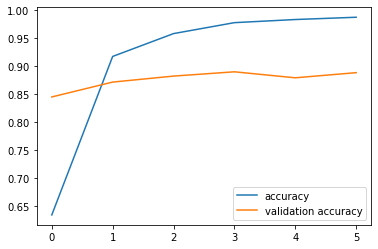

In [8]:
plt.plot(history_callback.history["acc"])
plt.plot(history_callback.history['val_acc'])
plt.legend(['accuracy', 'validation accuracy'])

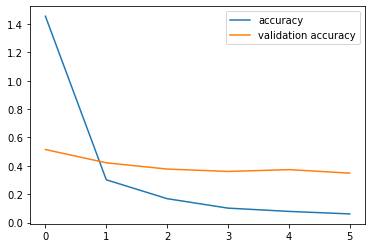

In [9]:
plt.plot(history_callback.history["loss"])
plt.plot(history_callback.history['val_loss'])
plt.legend(['accuracy', 'validation accuracy'])

In [11]:
score, acc = Inception.evaluate_generator(generator=validation_generator,
                                                    steps=Step_size_valid)

test_generator.reset()

pred = Inception.predict_generator(generator=test_generator,
                                   steps=Step_size_test,
                                   verbose=1)
predicted_class_indces = np.argmax(pred, axis=1)

777/777 [==============================] - 50s 64ms/step


In [12]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indces]

In [13]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv("results.csv", index=False)

In [14]:
print("Test score ", score)
print("Test acc", acc)
results

Test score  0.3506410440704862
Test acc 0.88678277


,Filename,Predictions
0,Abyssinian/Abyssinian_1.jpg,Abyssinian
1,Abyssinian/Abyssinian_10.jpg,Abyssinian
2,Abyssinian/Abyssinian_11.jpg,Abyssinian
3,Abyssinian/Abyssinian_12.jpg,Siamese
4,Abyssinian/Abyssinian_13.jpg,Abyssinian
...,...,...
772,yorkshire_terrier/yorkshire_terrier_4.jpg,yorkshire_terrier
773,yorkshire_terrier/yorkshire_terrier_5.jpg,yorkshire_terrier
774,yorkshire_terrier/yorkshire_terrier_6.jpg,yorkshire_terrier
775,yorkshire_terrier/yorkshire_terrier_7.jpg,yorkshire_terrier
